In [87]:
# Importing all the necessary libraries
!pip install category_encoders
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import plotly.express as px
from ipywidgets import interact, Dropdown, FloatSlider, IntSlider

Cleaning data files one-by-one does not make sense. This isn't an issue when I am working with just three files, but for several hundred files it's a bummer! One way to automate the data importing and cleaning process is by writing a **function**. This will make sure that all our data undergoes the same process, and that our analysis is easily reproducible — something that's very important in science in general and data science in particular.

Therefore, defining a wrangle function that takes the name of a CSV file as input and returns a DataFrame. The function involve following steps:-

- Filtered the data in the CSV file and return only apartments in Mexico City ("Distrito Federal") that cost less than $100,000.
- Removed outliers by trimming the bottom and top 10% of properties in terms of "surface_covered_in_m2".
- Created separate "lat" and "lon" columns.
- Mexico City is divided into 15 boroughs. Created a "borough" feature from the "place_with_parent_names" column.
- Drop columns that are more than 50% null values.
- Dropped columns containing low- or high-cardinality categorical values.
- Dropped any columns that constitute leakage for the target "price_aprox_usd".
- Dropped any columns that create issues of multicollinearity.

In [71]:
def wrangle(filepath):
    # Reading data
    df = pd.read_csv(filepath)

    #Data Filtering
    df = df.query("place_with_parent_names.str.contains('Distrito Federal') and property_type=='apartment' and price_aprox_usd<100000")

    # removing outlier values via surface_covered_in_m2 column
    low, high = df.surface_covered_in_m2.quantile([0.1, 0.9])
    df = df[df.surface_covered_in_m2.between(low, high)]

    # New features
    df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand = True).astype('float')
    df['borough'] = df.place_with_parent_names.str.split('|').str[1]

    # Dropping columns: 1. Features have alread been dervied 2. Because of more than 50% nan values
    # 3. Low or high cardinality (categories are low or high) 4. Leakage
    df.drop(columns = ['lat-lon', 'place_with_parent_names'], inplace = True)
    df.drop(columns = ['price_usd_per_m2', 'floor', 'rooms', 'expenses', 'surface_total_in_m2'], inplace = True)
    df.drop(columns = ['operation', 'property_type', 'currency', 'properati_url'], inplace = True)
    df.drop(columns = ['price_aprox_local_currency', 'price', 'price_per_m2'], inplace = True)

    df.drop(columns = 'Unnamed: 0', inplace=True)

    return df

In [72]:
# Glob to do pattern mathcing for csv files, making combined data in df
files = glob.glob('./data/mexico-city-real-estate-*')
files
frame = [wrangle(path) for path in files]
df = pd.concat(frame) # ([frame[i] for i in range(len(files))], ignore_index = True)
print(f"shape of dataframe = {df.shape}")
print(df.info())

shape of dataframe = (5473, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 5473 entries, 0 to 4618
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB
None


# EDA: Exploratory Data Analysis

<Axes: >

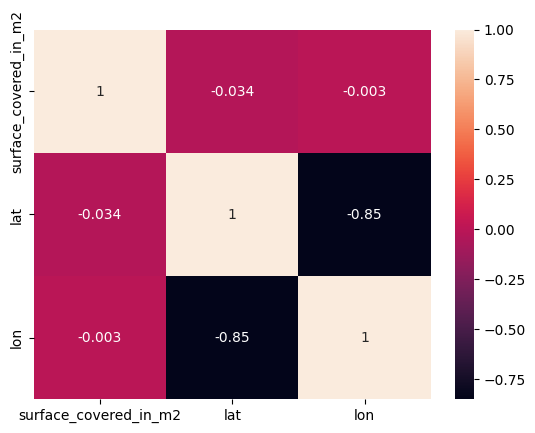

In [73]:
corr = df.select_dtypes("number").drop('price_aprox_usd', axis=1).corr()
sns.heatmap(corr, annot=True)

In [74]:
df.borough.value_counts()

borough
Benito Juárez             898
Cuauhtémoc                814
Álvaro Obregón            504
Miguel Hidalgo            490
Azcapotzalco              465
Iztapalapa                451
Coyoacán                  388
Gustavo A. Madero         359
Venustiano Carranza       338
Iztacalco                 335
Tlalpan                   194
Tláhuac                   155
Xochimilco                 46
La Magdalena Contreras     21
Cuajimalpa de Morelos      15
Name: count, dtype: int64

In [75]:
df.select_dtypes('object').nunique()

borough    15
dtype: int64

Based on a common assumption that property size is an important factor in determining price. With that in mind, let's look at the distribution of apartment sizes in our dataset. Below I created a histogram showing the distribution of apartment prices ("price_aprox_usd") in df. It seems, the data is not skewed as I have removed the 10 to 90%% of the quantiles from area. Earlier the data was right skewed.

Text(0.5, 1.0, 'Distribution of Apartment Prices')

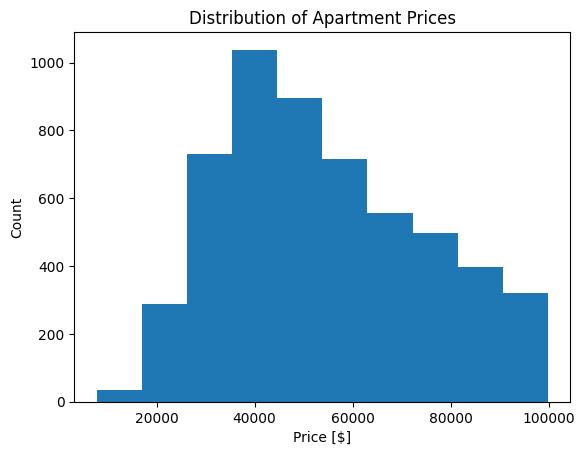

In [76]:
# Build histogram
plt.hist(df.price_aprox_usd)

# Label axes
plt.xlabel('Price [$]')
plt.ylabel("Count")

# Add title
plt.title("Distribution of Apartment Prices")

Created a scatter plot that shows apartment price ("price_aprox_usd") as a function of apartment size ("surface_covered_in_m2"). The plot shows the price varies for individual areas in different places.

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

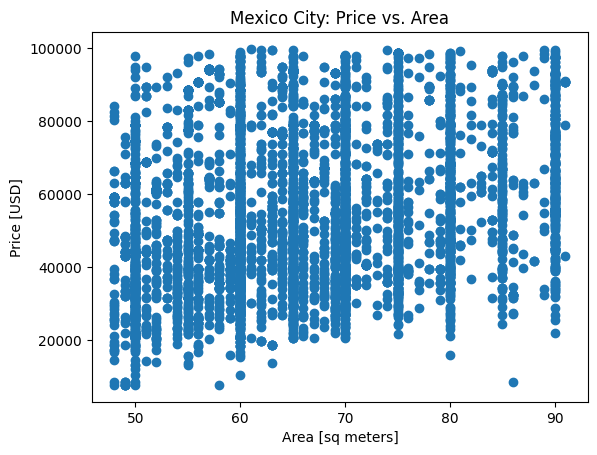

In [77]:
# Build scatter plot
plt.scatter(y = df.price_aprox_usd, x = df.surface_covered_in_m2)


# Label axes
plt.xlabel('Area [sq meters]')
plt.ylabel('Price [USD]')
# Add title
plt.title('Mexico City: Price vs. Area')

Created Mapbox scatter plot that shows the location of the apartments in the dataset and represent their price using color. Eastern areas of the city seem to have higher real estate prices?

In [46]:
# Plot Mapbox location and price
fig = px.scatter_mapbox(df, lat = 'lat', lon = 'lon', hover_name = 'borough', hover_data = 'surface_covered_in_m2', color = 'price_aprox_usd')

fig.update_layout(
    mapbox_style="open-street-map",  # Mapbox style
    mapbox_zoom=3,  # Zoom level
    mapbox_center={"lat": 37.7749, "lon": -122.4194}  # Center of the map
)

fig.show()

# Split Data and Baseline

In [78]:
# Created feature matrix X_train and target vector y_train. Target is "price_aprox_usd"
X_train = df.drop('price_aprox_usd', axis=1)
y_train = df['price_aprox_usd']

In [82]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5473 entries, 0 to 4618
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  5473 non-null   float64
 1   lat                    5149 non-null   float64
 2   lon                    5149 non-null   float64
 3   borough                5473 non-null   object 
dtypes: float64(3), object(1)
memory usage: 213.8+ KB


In [79]:
# Calculate the baseline mean absolute error for the model.
y_mean = y_train.mean()
y_pred_baseline = [y_mean for _ in range(len(y_train))]
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


In [107]:
# Read the test file
X_test = pd.read_csv('./data/mexico-city-test-features.csv', index_col=0)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1041 entries, 1 to 1041
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 40.7+ KB


# Model Build

- Created a pipeline named model that contains all the transformers necessary for this dataset. Earlier We simply dropped rows that contained NaN values, but this isn't ideal. Models generally perform better when they have more data to train with, so every row is precious. Instead, we can fill in these missing values using information we get from the whole column — a process called imputation. There are many different strategies for imputing missing values, and one of the most common is filling in the missing values with the mean of the column. I chose SimpleImputer for simplicity.

-  A model may require multiple transformers, and doing all those transformations one-by-one is slow and likely to lead to errors. Instead, we can combine our transformer and predictor into a single object called a `mak_pipeline`


## Linear Regression

In [109]:
model_lr = make_pipeline(OneHotEncoder(), SimpleImputer(), LinearRegression())
# Fit model
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['borough'])),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [88]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X_train, y_train, test_size = 0.2,
                                                 random_state = 42)
print("X_train shape:", X1_train.shape)
print("y_train shape:", y1_train.shape)
print("X_test shape:", X1_val.shape)
print("y_test shape:", y1_val.shape)

X_train shape: (4378, 4)
y_train shape: (4378,)
X_test shape: (1095, 4)
y_test shape: (1095,)


In [111]:
y1_pred = model_lr.predict(X_val)
print("Training MAE:", mean_absolute_error(y1_val, y1_pred))

ValueError: Found input variables with inconsistent numbers of samples: [5473, 1041]

In [94]:
y1_pred_test = pd.Series(model_lr.predict(X_test))
y1_pred_test.info()

0    53547.834628
1    53189.904721
2    34240.847702
3    53497.931113
4    68753.555672
dtype: float64

In [95]:
intercept = model_lr.named_steps["linearregression"].intercept_
coefficients = model_lr.named_steps["linearregression"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 18
[  291.08883606   482.26929743 -2486.16731914 -6676.21719732
 13778.25472927]


In [96]:
feature_names = model_lr.named_steps["onehotencoder"].get_feature_names_out()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 18
['surface_covered_in_m2' 'lat' 'lon' 'borough_1' 'borough_2']


In [97]:
feat_imp = pd.Series(coefficients, index = feature_names)
feat_imp.head()

surface_covered_in_m2      291.088836
lat                        482.269297
lon                      -2486.167319
borough_1                -6676.217197
borough_2                13778.254729
dtype: float64

In [98]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = -222406.89
+ (291.09 * surface_covered_in_m2)
+ (482.27 * lat)
+ (-2486.17 * lon)
+ (-6676.22 * borough_1)
+ (13778.25 * borough_2)
+ (3265.14 * borough_3)
+ (-370.24 * borough_4)
+ (3730.6 * borough_5)
+ (-5647.28 * borough_6)
+ (385.01 * borough_7)
+ (10354.8 * borough_8)
+ (2446.32 * borough_9)
+ (-13400.89 * borough_10)
+ (1962.98 * borough_11)
+ (-14282.52 * borough_12)
+ (931.28 * borough_13)
+ (-6226.16 * borough_14)
+ (9748.92 * borough_15)


Text(0.5, 1.0, 'Feature Importance for Apartment Price')

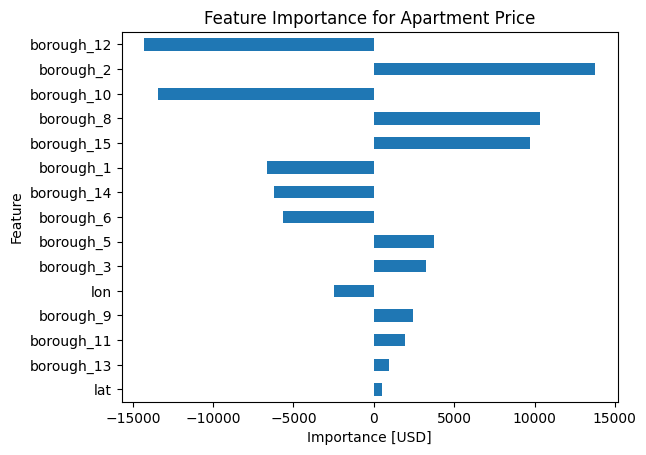

In [99]:
feat_imp.sort_values(key=abs).tail(15).plot(kind = "barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price")

## Ridge Model

In [101]:
# Build Model
model = make_pipeline(OneHotEncoder(use_cat_names=True), SimpleImputer(), Ridge()) # Intially tested on Linear regression but bad results so applied Ridge
# Fit model
model.fit(X1_train, y1_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [102]:
y_test_pred = pd.Series(model.predict(X1_val))
print("Training MAE:", mean_absolute_error(y1_val, y1_pred))

Training MAE: 14946.236186298915


 Created a Series named feat_imp. The index contain the names of all the features the model considers when making predictions; the values are the coefficient values associated with each feature. The Series is sorted by absolute value in ascending order

In [103]:
coefficients = model.named_steps['ridge'].coef_
features = model.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(index = features, data = coefficients)
feat_imp

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:366: FutureWarning:

`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.



surface_covered_in_m2               300.995225
lat                                 893.870919
lon                               -2281.804037
borough_Azcapotzalco               2132.687807
borough_Álvaro Obregón             3018.216224
borough_Venustiano Carranza       -5147.700675
borough_Cuauhtémoc                 -107.905811
borough_Iztapalapa               -13090.593797
borough_Tlalpan                   11416.938023
borough_Iztacalco                  1496.579554
borough_Miguel Hidalgo             1501.197872
borough_Coyoacán                   2907.225895
borough_Benito Juárez             13628.710222
borough_Gustavo A. Madero         -6944.817960
borough_Tláhuac                  -14683.346317
borough_Xochimilco                 1783.523658
borough_La Magdalena Contreras    -7397.837467
borough_Cuajimalpa de Morelos      9487.122773
dtype: float64

Created a horizontal bar chart that shows the 10 most influential coefficients for the model.

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

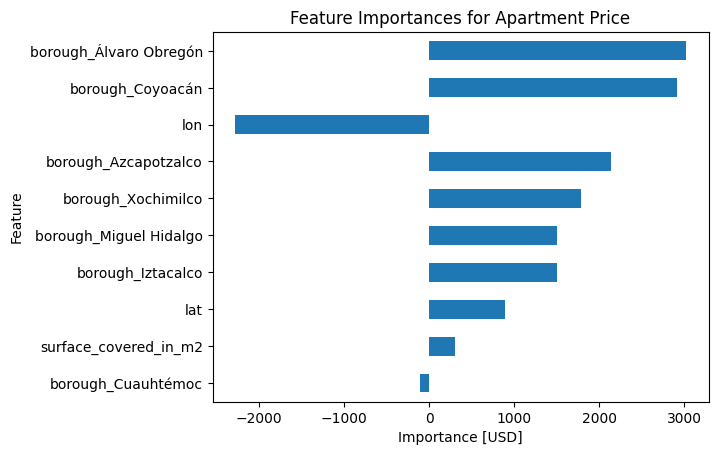

In [104]:
feat_imp.sort_values(key=abs).head(10).plot(kind='barh')

# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")

# Add title
plt.title("Feature Importances for Apartment Price")

Created a function make_prediction that takes four arguments (area, lat, lon, and neighborhood) and returns the model's prediction for an apartment price. User can adjust the widget to see how predicted apartment price changes.

In [105]:
def make_prediction(area, lat, lon, borough):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "borough": borough
    }
    df = pd.DataFrame(data, index = [0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"
make_prediction(100, 18, -100, "Azcapotzalco")

'Predicted apartment price: $65836.61'

In [106]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    borough=Dropdown(options=sorted(X_train["borough"].unique())),
);

interactive(children=(IntSlider(value=66, description='area', max=91, min=48), FloatSlider(value=19.4531123034…